<a href="https://colab.research.google.com/github/DouaaBennoune/news_ai_summarizer/blob/main/arabic_news_summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Libraries


In [1]:
!pip install pandas numpy transformers datasets torch evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━

# Uploading DataSet

In [2]:
import torch
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

from google.colab import drive
drive.mount('/content/drive')
import os
for root, dirs, files in os.walk('/content/drive/MyDrive'):
    print(root)
    for file in files:
        print(file)
import pandas as pd

# Replace this path with the actual path to your file
file_path = '/content/drive/MyDrive/bbc_news_arabic_summarization.csv'

# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

GPU available: False
Using CPU
Mounted at /content/drive
/content/drive/MyDrive
Bennoune D.jpg
Lesson Schedule.gsheet
Document sans titre (11).gdoc
Rapport TP1 modelisation.gdoc
thesis plan.gdoc
50 Free Online Courses.pdf
raspberry Pi and ESP32 Connection Methodes.gdoc
Rapport boussaha el batoul.pdf
Recemmend project for each section from small to b....gdoc
Did you actually make a rezearch on the german job....gdoc
Image Classification and K-Nearest Neighbors (KNN).gdoc
IBM  Introduction to Computer Vision Course Summary.gdoc
Write me a roadmap that makes me have a solid base....gdoc
fig.gdoc
filament recycling project.gdoc
Rapport (4).gdoc
batoul.gdoc
schedule of this month.gdoc
Achieving high-quality filament.gdoc
german A1 plan.gdoc
AI filament.gdoc
electronique de puissance.pdf
electronique de puissance.gdoc
meilleur resume chapitre 2 electronique.gdoc
TP1 microprocesseur initiation  .gdoc
Document sans titre (10).gdoc
tp 2 assembleur.gdoc
serie 1 electronique.gdoc
Rapport de puiss

# Exploring Data

In [3]:
import pandas as pd
file_path = '/content/drive/MyDrive/bbc_news_arabic_summarization.csv'

df = pd.read_csv(file_path)
print(df.head())
print(df.info())



                                        id  \
0  140323_russian_troops_crimea_naval_base   
1                    130528_egypt_nile_dam   
2                           world-47242349   
3                        vert-cul-55078328   
4                     141023_yemen_hodeida   

                                                 url  \
0  https://www.bbc.com/arabic/worldnews/2014/03/1...   
1  https://www.bbc.com/arabic/middleeast/2013/05/...   
2          https://www.bbc.com/arabic/world-47242349   
3       https://www.bbc.com/arabic/vert-cul-55078328   
4  https://www.bbc.com/arabic/middleeast/2014/10/...   

                                               title  \
0           القوات الأوكرانية تبدأ الانسحاب من القرم   
1    هل يفرض سد النهضة الإثيوبي واقعا جديدا على مصر؟   
2  تعرف على منطقة كشمير التي تسببت بحربين بين اله...   
3  ماذا تعرف عن العالم الخفي للمعابد اليابانية ال...   
4  اشتباك بين الحوثيين و"الحراك التهامي" في الحدي...   

                                             summ

**Token Length**

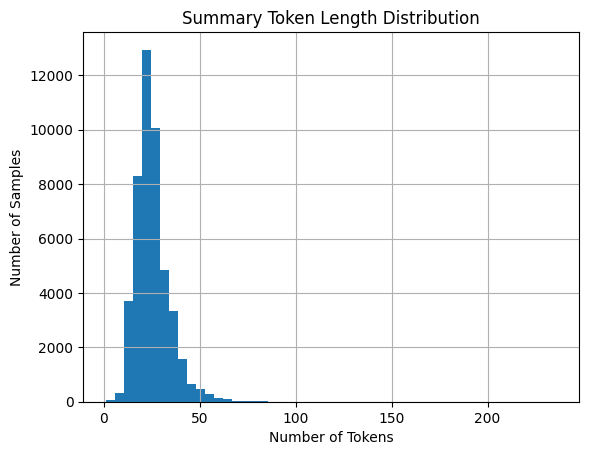

In [4]:
import matplotlib.pyplot as plt
df['summary_length'] = df['summary'].apply(lambda x: len(str(x).split()))

# Show distribution
df['summary_length'].hist(bins=50)
plt.title("Summary Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Samples")
plt.show()

we notice our max length can be : 50

Text(0, 0.5, 'Number of Samples')

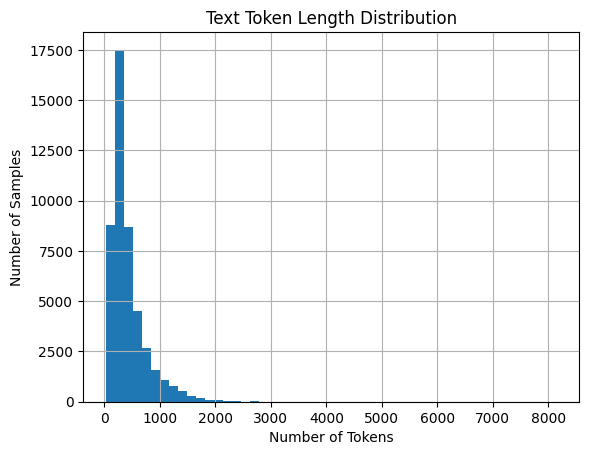

In [5]:
from ast import Lambda
df['text_length']=df['text'].apply(lambda x: len(str(x).split()))
df['text_length'].hist(bins=50)
plt.title("Text Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Samples")

we notice that our max length can be: 512
or max_length = 1024 if resources allow

#  Loading the Model and Dataset

In [7]:
import torch
from transformers import MT5ForConditionalGeneration, MT5TokenizerFast
import pandas as pd
from datasets import Dataset

# Load pretrained model and tokenizer
model_name = "csebuetnlp/mT5_multilingual_XLSum"
model = MT5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = MT5TokenizerFast.from_pretrained(model_name)

# Load your Arabic news dataset

dataset = Dataset.from_pandas(df)

# Split the dataset
dataset = dataset.train_test_split(test_size=0.1)



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5TokenizerFast'.
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


# Creating the Custom Head and Freezing Base Model

In [ ]:
import torch
import torch.nn as nn
from transformers import MT5ForConditionalGeneration, T5Tokenizer
from transformers import Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import evaluate
import numpy as np

# Check for GPU
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Load the base model FIRST before trying to use it
model_name = "csebuetnlp/mT5_multilingual_XLSum"
base_model = MT5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)  # Using T5Tokenizer to avoid warnings

class Adapter(nn.Module):
    def __init__(self, hidden_size, adapter_size):
        super().__init__()
        self.down = nn.Linear(hidden_size, adapter_size)
        self.activation = nn.ReLU()
        self.up = nn.Linear(adapter_size, hidden_size)

        # Initialize to be near-identity
        nn.init.normal_(self.down.weight, std=1e-2)
        nn.init.normal_(self.up.weight, std=1e-2)
        nn.init.zeros_(self.down.bias)
        nn.init.zeros_(self.up.bias)

    def forward(self, x):
        return self.up(self.activation(self.down(x))) + x

# Create a custom class for the adapter-based model
class AdapterMT5(nn.Module):
    def __init__(self, mt5_model, adapter_size=64):
        super().__init__()
        self.mt5 = mt5_model

        # Freeze the base model
        for param in self.mt5.parameters():
            param.requires_grad = False

        # Get the hidden size from the model
        hidden_size = self.mt5.config.d_model

        # Add adapters to select encoder layers
        self.encoder_adapters = nn.ModuleList([
            Adapter(hidden_size, adapter_size)
            for _ in range(len(self.mt5.encoder.block) // 3)  # Add to every third layer
        ])

        # Add a decoder adapter
        self.decoder_adapter = Adapter(hidden_size, adapter_size)

    def forward(self, **kwargs):
        # Just pass through to the original model during training
        return self.mt5(**kwargs)

    def generate(self, *args, **kwargs):
        # For generation, use the base model's generate method
        return self.mt5.generate(*args, **kwargs)

# Create the adapter-enhanced model (only ONCE)
model = AdapterMT5(base_model)

# Move model to GPU if available
model.to(device)

# Verify which parameters are trainable
trainable_params = 0
all_params = 0
for name, param in model.named_parameters():
    all_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(f"Trainable parameters: {trainable_params:,} ({100 * trainable_params / all_params:.2f}% of all parameters)")


# Preprocess function
def preprocess_function(examples):
    # Prefix for mT5 summarization task
    prefix = "summarize Arabic: "
    inputs = [prefix + doc for doc in examples["text"]]

    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(examples["summary"], max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    # Replace padding token id with -100 so it's ignored in loss computation
    model_inputs["labels"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in model_inputs["labels"]
    ]

    return model_inputs

# Metric function for evaluation
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # For regular eval, not generation
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # If using generation during evaluation (which we're not for now)
    # decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 with pad token id for decoding
    # labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # For now, just report loss
    return {"loss": np.mean(np.abs(predictions - labels))}


# Load your dataset


# Preprocess the data
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Define training arguments WITHOUT predict_with_generate
training_args = TrainingArguments(
    output_dir="./results",
    eval_steps=1000,                 # Evaluate every 1000 steps
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    logging_dir="./logs",
)

# Initialize the trainer with the BASE model, not the wrapper
trainer = Trainer(
    model=model.mt5,  # Use the base MT5 model directly with the trainer
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the model
trainer.save_model("./arabic_news_summarizer")
tokenizer.save_pretrained("./arabic_news_summarizer")



# Define custom evaluation function that uses generation
def evaluate_model(model, test_dataset, tokenizer, device):
    model.eval()
    rouge = evaluate.load("rouge")
    results = []

    # Process a small batch for demonstration
    for i, example in enumerate(test_dataset):
        if i >= 10:  # Just evaluate 10 examples for demo
            break

        input_text = "summarize Arabic: " + example["text"]
        inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)

        with torch.no_grad():
            generated_ids = model.generate(
                inputs["input_ids"],
                max_length=128,
                min_length=30,
                num_beams=4,
                early_stopping=True
            )

        generated_summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        actual_summary = example["summary"]

        # Compute ROUGE scores
        rouge_scores = rouge.compute(predictions=[generated_summary], references=[actual_summary])
        results.append(rouge_scores)

        print(f"Example {i+1}:")
        print(f"Generated: {generated_summary}")
        print(f"Actual: {actual_summary}")
        print(f"ROUGE scores: {rouge_scores}\n")

    # Average scores
    avg_scores = {key: sum(r[key] for r in results) / len(results) for key in results[0].keys()}
    print(f"Average ROUGE scores: {avg_scores}")

    return avg_scores

# After training, evaluate with generation
print("Evaluating model with generation...")
evaluate_model(model, tokenized_datasets["test"], tokenizer, device)

# Test your model with a sample input
def generate_summary(text):
    inputs = tokenizer("summarize Arabic: " + text, return_tensors="pt").to(device)
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=128,
        min_length=30,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example usage
sample_article = "قالت منظمة الصحة العالمية إن فيروس كورونا المستجد يشكل تهديدا عالميا خطيرا، لكنها أعربت عن ثقتها في قدرة الصين على احتواء الفيروس. وقالت المنظمة إن الوباء الذي ظهر في الصين أواخر العام الماضي لم يتحول إلى وباء عالمي. وقد أبلغت الصين عن 425 حالة وفاة و20,438 حالة إصابة مؤكدة بالفيروس، في حين تم الإبلاغ عن أكثر من 150 حالة في دول أخرى."
print(generate_summary(sample_article))

GPU available: False
Using CPU
Trainable parameters: 495,680 (0.09% of all parameters)


Map:   0%|          | 0/42207 [00:00<?, ? examples/s]